In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for file editing
import shutil # for console commands
from tensorflow import keras
import  tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation, Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import VGG16

### **Loading the image data**

My decisions and steps I took: 
Generally speaking, the development of a ML system in production is an iterative process consisting of project scoping, data engineering, model development, deployment, monitoring, continual learning and business analysis. 
In the problem, since we are dealing with image data, the data engineering time was mainly spent on data preparation for training and testing, including data loading, resizing, scaling, splitting, data augmentation (ImageDataGenerator class is used, which ensures that the model receives new variations of images at each epoch); instead of feature selection (percentage of missing values, amount of variation, pairwise correlation, correlation with target, PCA, etc.) and feature engineering.



In [4]:
#only extract jpg files
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo

In [3]:
# extract function
def untar(fname,path="flowers17"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path="flowers17", members=jpg_files(tar))
    tar.close()
    if path == "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to ",  path)

In [4]:

import tarfile
import urllib
def download(filename, source_url, work_directory):
    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    print(filepath )
    if not os.path.exists(filepath): # check if file exists; if not, download
        print("Downloading file, Please wait...")
        filepath, _ = urllib.request.urlretrieve(source_url + filename, # this is a function to download files
                                                 filepath)
        statinfo = os.stat(filepath)
        print(statinfo)
        print(('Succesfully downloaded', filename, statinfo.st_size, 'bytes.'))
        untar(filepath,work_directory)
    return filepath

In [5]:
download("17flowers.tgz", "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/","flowers17")

flowers17/17flowers.tgz


'flowers17/17flowers.tgz'

In [6]:
os.listdir("./flowers17/") #jpg folder should be available

['train', '17flowers.tgz', 'test', 'jpg']

In [7]:
class_names = ["daffodil", "snowdrop", "lilyvalley", "bluebell", "crocus",
			   "iris", "tigerlily", "tulip", "fritillary", "sunflower", 
			   "daisy", "coltsfoot", "dandelion", "cowslip", "buttercup",
			   "windflower", "pansy"]

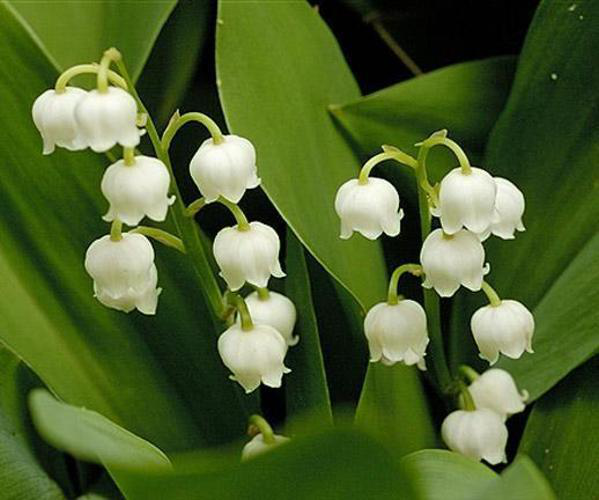

In [10]:
from PIL import Image #show one example of image
root='./flowers17/jpg/'
filename = "image_{0:04d}.jpg".format(np.random.randint(1,1360))
file_path = os.path.join(root, filename)
Image.open(file_path)

In [8]:
#load images as np arrays
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img

In [11]:
#all images are loaded as np arrays
images=[]
labels=[]
total=1361
j=1
for i in range(1, total): 
    fname="./flowers17/jpg/image_"    
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    images.append(load_data(fpath))
    labels.append(j) #labels are created as well
    if i%80==0: j+=1

In [12]:
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

(1360, 224, 224, 3)

### **Spliting into train, and test sets**

In [13]:
# split data into training and test
from sklearn.model_selection import train_test_split 
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size = 0.7, random_state =  104)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


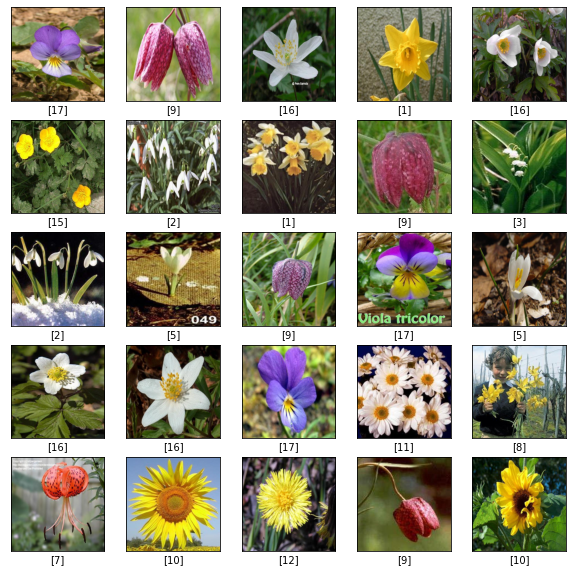

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) # plot 25 images
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]/255, cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

In [14]:
# dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np
def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname): #check if the folder exists; if not make dir
      os.mkdir(dirname)
    n=0
    
    for i in data:
      label_n=labels[n][0]
      subfolder = folder + "/" + str(label_n) 
      if not os.path.exists(subfolder): # create subfolders with categories
          os.mkdir(subfolder)  
      filepath =  subfolder + "/" + str(n)+ ".jpg"
      cv2.imwrite(filepath, cv2.cvtColor(data[n], cv2.COLOR_RGB2BGR)) #save image to corresponding subfolders
      n+=1

In [15]:
create_images(test_images, test_labels, './flowers17/test')

In [16]:
create_images(train_images, train_labels, './flowers17/train') #save image to corresponding subfolders

In [17]:
train_dir =os.path.realpath('./flowers17/train')
validation_dir = os.path.realpath('./flowers17/test')
image_size = 224

### **Data Augmentation**

For model deployment, regarding the image data, we have many well-trained models on rich image dataset. So, we can use transfer learning to transfer the knowledge of the models to our specific model. In this case, I chose VGG16 and trained the model while freezing the convolutional layers. The other options are to choose a different standard model architecture (Inception, ResNet, etc.) with or without freezing weights.
Finally, the results were visualized.

In [18]:
# image augmentation for train set and image resizing for validation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # this function will generate augmented images in real time
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255) # for validation we don't need to augment

train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory( # this function takes images from folders and feeds to Imagedatagenerator
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1976 images belonging to 17 classes.
Found 409 images belonging to 17 classes.


### **Model building (simple and base model)**

In [20]:
# set model constants
num_classes = 17
image_size = 224
input_shape=(image_size, image_size, 3)

# define model as Sequential
model_base = Sequential()

# first convolutional layer with 32 filters
model_base.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 3)))

# add a second 2D convolutional layer with 64 filters
model_base.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
# reduce dimensionality through max pooling
model_base.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 16 filters
model_base.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model_base.add(Dropout(0.25))
# necessary flatten step preceeding dense layer
model_base.add(Flatten())
# fully connected layer
model_base.add(Dense(100, activation='relu'))

# add additional dropout to prevent overfitting
model_base.add(Dropout(0.5))

# prediction layers
model_base.add(Dense(num_classes, activation="sigmoid", name='preds'))

# show model summary
# model_base.build(input_shape)
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 16)      2320      
                                                                 
 dropout (Dropout)           (None, 108, 108, 16)      0         
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                        

### **Hyperparameter Tuning (learning rate)**

I started by showing the results of tuning the hyperparameters. One of the hyperparameters is the learning rate. According to the Fig. 1, the appropriate lr is determined for the Adam optimizer to be between 1e-4 and 1e-3. We can also examine other optimizers (SGD, RMSprop, etc.), and other hyperparameters (kernel size, dropout rate, etc.).

In [ ]:
epoch = 100
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_base.compile(loss='categorical_crossentropy', optimizer=optimizer)
history = model_base.fit(train_generator,epochs=epoch, callbacks=[lr_schedule], verbose=1)#

Epoch 1/100
11/11 [==============================] - 12s 1s/step - loss: 1.8190 - lr: 1.0000e-05
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 1.8418 - lr: 1.1220e-05
Epoch 3/100
11/11 [==============================] - 12s 1s/step - loss: 1.7821 - lr: 1.2589e-05
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 1.7744 - lr: 1.4125e-05
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 1.7681 - lr: 1.5849e-05
Epoch 6/100
11/11 [==============================] - 12s 1s/step - loss: 1.8099 - lr: 1.7783e-05
Epoch 7/100
11/11 [==============================] - 12s 1s/step - loss: 1.7624 - lr: 1.9953e-05
Epoch 8/100
11/11 [==============================] - 12s 1s/step - loss: 1.7469 - lr: 2.2387e-05
Epoch 9/100
11/11 [==============================] - 12s 1s/step - loss: 1.7241 - lr: 2.5119e-05
Epoch 10/100
11/11 [==============================] - 12s 1s/step - loss: 1.7459 - lr: 2.8184e-05
Epoch 11/100
11/11 [=========

In [21]:
lrs = 1e-5 * (10 ** (np.arange(epoch) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 0, 1, 7])

NameError: ignored

### **Compile and train base model**

Then, I show simulation results including accuracy and loss as shown in Fig. 2. If the data is imbalanced, other metrics (recall, precision, f1-score, etc.) should be considered. 
As we can see in the figure, for the custom model, the test accuracy is higher than the train accuracy! I think one reason is that the train data is being augmented. Although I reported the lowest accuracy, I tried to fix it by dedicating more data to test split (30%) (I should spend more time on this and still increase the test data.) I would like to mention that we mostly face with overfitting in this stage. The solutions for overfitting are to modify loss function, modify data sampling, or change training approach (weight noise injection, drop out, batch normalization)


In [22]:
model_base.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-3), # learning rate should be small so previously learned weights don't vanish
              metrics=['acc', 'top_k_categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
history1 = model_base.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/40
19/19 [==============================] - 29s 1s/step - loss: 2.6997 - acc: 0.1326 - top_k_categorical_accuracy: 0.5035 - val_loss: 2.4303 - val_acc: 0.2152 - val_top_k_categorical_accuracy: 0.6601
Epoch 2/40
19/19 [==============================] - 22s 1s/step - loss: 2.3760 - acc: 0.2191 - top_k_categorical_accuracy: 0.6559 - val_loss: 2.1391 - val_acc: 0.3472 - val_top_k_categorical_accuracy: 0.8093
Epoch 3/40
19/19 [==============================] - 23s 1s/step - loss: 2.2377 - acc: 0.2556 - top_k_categorical_accuracy: 0.7227 - val_loss: 1.9620 - val_acc: 0.3667 - val_top_k_categorical_accuracy: 0.8557
Epoch 4/40
19/19 [==============================] - 22s 1s/step - loss: 2.1002 - acc: 0.3128 - top_k_categorical_accuracy: 0.7682 - val_loss: 1.6872 - val_acc: 0.4817 - val_top_k_categorical_accuracy: 0.8924
Epoch 5/40
19/19 [==============================] - 22s 1s/step - loss: 2.0013 - acc: 0.3482 - top_k_categorical_accuracy: 0.7971 - val_loss: 1.6349 - val_acc: 0.5012 -

In [24]:
model_base.save('best_model.h5')

# **Visualize training history and simulation result (base model)**

In [25]:
print('training acc.:',history1.history['acc'][-1],'\n','test acc.:', (history1.history['val_acc'])[-1],'tarining loss:',(history1.history['loss'])[-1])

training acc.: 0.6209514141082764 
 test acc.: 0.6723716259002686 tarining loss: 1.0881600379943848


In [26]:
print(' training top 5:',history1.history['top_k_categorical_accuracy'][-1], '\n',
      'val top 5:', history1.history['val_top_k_categorical_accuracy'][-1], '\n')

 training top 5: 0.9504048824310303 
 val top 5: 0.9731051325798035 



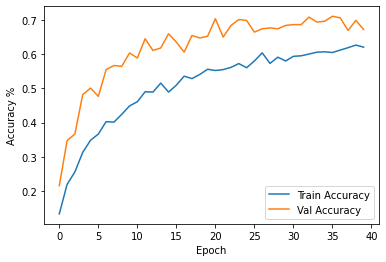

In [27]:
# plot the accuracy history
import matplotlib.pyplot as plt
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy %')
 plt.plot(history.epoch, np.array(history.history['acc']),
 label='Train Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_acc']),
 label = 'Val Accuracy')
 plt.legend()
#  plt.ylim([0.5, 1])
plot_history(history1)

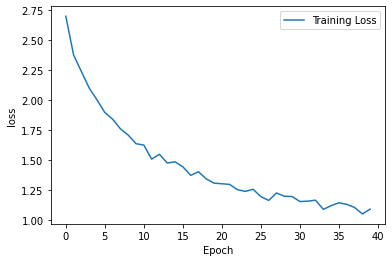

In [28]:
# plot the loss history
import matplotlib.pyplot as plt
def plot2_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('loss')
 plt.plot(history.epoch, np.array(history.history['loss']),
 label='Training Loss')
 plt.legend()
#  plt.ylim([0.5, 1])

plot2_history(history1)

### **Model building (VGG16 Transfered model) using transfer learning with freezed conv layers**


In [ ]:
# use vgg16 pre-trained model with trainable densely connected output layer


#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers except for the last layer: 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model_tf = models.Sequential()
 
# Add the vgg convolutional base model
model_tf.add(vgg_conv)
 
# Add new layers
model_tf.add(layers.Flatten())
model_tf.add(layers.Dense(1024, activation='relu'))
model_tf.add(layers.Dropout(0.5))
model_tf.add(layers.Dense(17, activation='softmax'))
model_tf.summary() 


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 17)                17425     
                                                                 
Total params: 40,423,249
Trainable params: 32,787,985
Non-trainable params: 7,635,264
_________________________________________________________________


### **Compile and train VGG16 transfered model**


In [ ]:

model_tf.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-4), # learning rate should be small so previously learned weights don't vanish
              metrics=['acc', 'top_k_categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# train the model with augmented images in real-time
history = model_tf.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/40
10/10 [==============================] - 17s 1s/step - loss: 3.0660 - acc: 0.0717 - top_k_categorical_accuracy: 0.3254 - val_loss: 3.3889 - val_acc: 0.0625 - val_top_k_categorical_accuracy: 0.3676
Epoch 2/40
10/10 [==============================] - 17s 2s/step - loss: 2.8792 - acc: 0.0901 - top_k_categorical_accuracy: 0.4127 - val_loss: 2.7908 - val_acc: 0.1103 - val_top_k_categorical_accuracy: 0.4081
Epoch 3/40
10/10 [==============================] - 16s 1s/step - loss: 2.6397 - acc: 0.1562 - top_k_categorical_accuracy: 0.4917 - val_loss: 2.4391 - val_acc: 0.2243 - val_top_k_categorical_accuracy: 0.6618
Epoch 4/40
10/10 [==============================] - 16s 1s/step - loss: 2.4290 - acc: 0.2381 - top_k_categorical_accuracy: 0.6369 - val_loss: 1.8781 - val_acc: 0.4044 - val_top_k_categorical_accuracy: 0.7721
Epoch 5/40
10/10 [==============================] - 16s 1s/step - loss: 2.0960 - acc: 0.3244 - top_k_categorical_accuracy: 0.7123 - val_loss: 1.6340 - val_acc: 0.4816 -

In [ ]:
model_base.save('Tf_best_model.h5')

### **Visualize training history and simulation result (VGG16 transfered model)**




In [ ]:
print('training acc.:',history.history['acc'][-1],'\n','test acc.:', (history.history['val_acc'])[-1],'tarining loss:',(history.history['loss'])[-1])

training acc.: 0.9944853186607361 
 test acc.: 0.9301470518112183 tarining loss: 0.02012140303850174


In [ ]:
print(' training top 5:',history.history['top_k_categorical_accuracy'][-1], '\n',
      'val top 5:', history.history['val_top_k_categorical_accuracy'][-1], '\n')

 training top 5: 1.0 
 val top 5: 1.0 



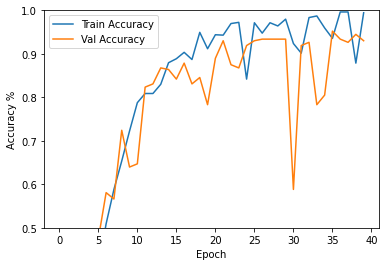

In [ ]:
# plot the accuracy history
import matplotlib.pyplot as plt
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy %')
 plt.plot(history.epoch, np.array(history.history['acc']),label='Train Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_acc']),
 label = 'Val Accuracy')
 plt.legend()
 plt.ylim([0.5, 1])
plot_history(history)

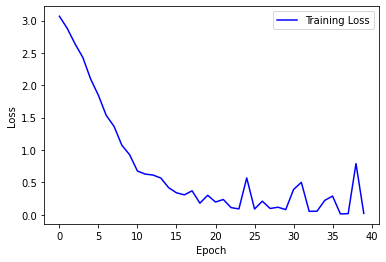

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_proba=model_tf.predict(test_images)

In [ ]:

idx=np.random.randint(0,272)
bars=[]
barprob=[]
indices =(-y_proba[idx]).argsort()[:5]
for i in indices:
  bars.append(class_names[i])
  barprob.append(y_proba[idx][i])

print(barprob)

[1.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:

fig = plt.figure(figsize=(4, 10))
ax1 = fig.add_subplot(2, 1, 1, xticks=[], yticks=[])
title = f'{bars[0]}'
ax1.imshow(test_images[idx]/255, cmap=plt.cm.binary)
ax1.set_title(title, color='red')
ax1.grid(False)

ax2 = fig.add_subplot(2, 1, 2, xticks=[], yticks=[])
ax2.barh(np.arange(5), barprob)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(bars)
ax2.set_ylim(-1, 5)
ax2.invert_yaxis()
ax2.set_xlim(0, 1.1)
ax2.set_title('Class Probability')
plt.show()


NameError: ignored